In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import copy
from keras.optimizers import Adam,RMSprop
from keras.models import Sequential
from keras.layers import *
from keras.optimizers import *
import pandas as pd
import seaborn as sns
import random
import math
%run AIPlayer.ipynb
%run SmallGame.ipynb
%run Game.ipynb
%run DDQNAgent.ipynb
%run SmallAgent.ipynb

In [40]:
#Training phase for 8x8 Agent
def initialize_game(agent):
    print("Starting random agent:")
    #creating memory for PER with random matches
    i=0
    while i < agent.memory_cap:
        b=Board(verbose=False)
        pl=AI(0)
        opp=AI(0)
        d=b.get_game_over()
        while d==False and i< agent.memory_cap:
            state_init1 = agent.get_state(b)
            action=pl.move(b)
            reward=agent.set_reward(b,action)
            b.coord_move(action)
            d=b.get_game_over()
            if(d==False):
                b.coord_move(opp.move(b))
                next_state= agent.get_state(b)
                d=b.get_game_over()
            else:
                next_state=np.zeros([64])
            next_state= agent.get_state(b)
            d=b.get_game_over()
            sample=(state_init1, action,reward, next_state, d)
            #I use the reward as error to remember in the memory
            error=abs(sample[2])
            i+=1
            agent.memory.add(error,sample)
    print("Ending of Random creating memory")
    
    
def plot_seaborn_score(array_counter, array_score):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_score])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='score')
    plt.show()
    
def plot_seaborn_win(array_counter, array_win):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_win])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='wins')
    plt.show()
    
def plot_seaborn_predicted(array_counter, array_pred):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_pred])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='number of predicted moves')
    plt.show()
    
def plot_seaborn_wrong(array_counter, array_wrong):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_wrong])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='times where i did a not valid move')
    plt.show()
    
def get_record(score, record):
        if score >= record:
            return score
        else:
            return record 
    
def run():

    agent = DQNAgent()
    print(agent.model.summary())
    counter_games = 0
    counter_move = 0
    counter_notfin = 0
    score_plot = []
    win_plot = []
    wrong_plot = []
    counter_plot =[]
    counter_predicted=[]
    record = 0
    #filling the memory
    initialize_game(agent)
        
    while counter_games < 8000:
        # Initialize classes
        board=Board(verbose=False)
        opponent = AI(0)
        counter_pred = 0        
        wrong_move=False
        
        done=board.get_game_over()

        while not done:
            
            #get old state
            state_old = agent.get_state(board)
            counter_move +=1
            
            #predict the move of the agent
            if random.random() < agent.epsilon:
                if(agent.epsilon < 0.01):
                    print("Possible move:")
                    state_old = agent.get_state(board)
                    possible_moves = board.get_valid_moves()  
                    possible_moves=list(zip(*possible_moves))
                    weights = np.zeros(len(possible_moves[0]))
                    p = np.exp(weights)
                    p /= np.sum(p)
                    choice = np.random.choice(range(len(weights)), p=p)
                    action = possible_moves[0][choice]
                else:
                    print("Random move:")
                    #giving out also wrong possibilities to get also their values for the q-function
                    mov=random.randint(0,63)
                    row=mov//8
                    column=mov%8
                    action=(row,column)
            else:
                print("Predicted move:")
                counter_pred +=1
                state_old = agent.get_state(board)
                pred=agent.predict(state_old.reshape((1,64)))[0]
                mov=np.argmax(pred)
                row=mov//8            
                column=mov%8
                action=(row,column)
    
            #get the reward of the move predicted
            reward= agent.set_reward(board,action)
                
            #perform new move and get new state
            #I also get if the game is ended or not
            print(action)
            try:
                board.coord_move(action)
                done=board.get_game_over()
            except:
                print("Player did a not valid move")
                #ending manually the loop
                wrong_move=True
                done=True
                
            #opponent make move
            #the next state is the state after the move of the opponent so it's again the move of the agent
            if(done==False):
                board.coord_move(opponent.move(board))
                next_state= agent.get_state(board)
                #inspecting if the game ended after the opponent move
                done=board.get_game_over()
            else:
                next_state=np.zeros([64])
            
            # store the new data into a long term memory for the all game
            agent.remember(state_old, action,reward, next_state, done)
            
            #train with replay new
            agent.replay()
            
            #save score for final plot
            record = get_record(board.get_black_score(), record)           
            
        counter_games += 1
        print('Game', counter_games, '      Score:', board.get_black_score())
        score_plot.append(board.get_black_score())
        if board.get_black_score()>=board.get_white_score():
            if wrong_move==True:
                #I did a non valid move and just for a case I had more points but i lost
                win_plot.append(0)
                wrong_plot.append(1)
            else:
                win_plot.append(1)
                wrong_plot.append(0)
        else:
            win_plot.append(0)
            wrong_plot.append(0)
        counter_plot.append(counter_games)
        counter_predicted.append(counter_pred)
    agent.model.save_weights('8x8_weights_new.hdf5')
    plot_seaborn_score(counter_plot, score_plot)
    plot_seaborn_win(counter_plot,win_plot)
    plot_seaborn_predicted(counter_plot,counter_predicted)
    plot_seaborn_wrong(counter_plot,wrong_plot)

In [36]:
#Training phase for 4x4 Agent
def initialize_gameS(agent):
    print("Starting random agent:")
    #creating memory for PER with random matches
    i=0
    while i < agent.memory_cap:
        b=SmallBoard(verbose=False)
        #b=Board(verbose=False)
        pl=AI(0)
        opp=AI(0)
        d=b.get_game_over()
        while d==False and i< agent.memory_cap:
            state_init1 = agent.get_state(b)
            action=pl.move(b)
            reward=agent.set_reward(b,action)
            b.coord_move(action)
            d=b.get_game_over()
            if(d==False):
                b.coord_move(opp.move(b))
                next_state= agent.get_state(b)
                d=b.get_game_over()
            else:
                next_state=np.zeros([16])
            next_state= agent.get_state(b)
            d=b.get_game_over()
            sample=(state_init1, action,reward, next_state, d)
            #I use the reward as error to remember in the memory
            error=abs(sample[2])
            i+=1
            agent.memory.add(error,sample)
    print("Ending of Random creating memory")
    
    
def plot_seaborn_scoreS(array_counter, array_score):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_score])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='score')
    plt.show()
    
def plot_seaborn_winS(array_counter, array_win):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_win])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='wins')
    plt.show()
    
def plot_seaborn_predictedS(array_counter, array_pred):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_pred])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='number of predicted moves')
    plt.show()
    
def plot_seaborn_wrongS(array_counter, array_wrong):
    sns.set(color_codes=True)
    ax = sns.regplot(np.array([array_counter])[0], np.array([array_wrong])[0], color="b", x_jitter=.1, line_kws={'color':'green'})
    ax.set(xlabel='games', ylabel='times where i did a not valid move')
    plt.show()
    
def get_recordS(score, record):
        if score >= record:
            return score
        else:
            return record 
    
def runS():

    agent = DQNSmallAgent()
    print(agent.model.summary())
    counter_games = 0
    counter_move = 0
    counter_notfin = 0
    score_plot = []
    win_plot = []
    wrong_plot = []
    counter_plot =[]
    counter_predicted=[]
    record = 0
    #filling the memory
    initialize_gameS(agent)
        
    while counter_games < 7000:
        # Initialize classes
        board = SmallBoard(verbose=False)
        #b=Board(verbose=False)
        opponent = AI(0)
        counter_pred = 0        
        wrong_move=False
        
        done=board.get_game_over()

        while not done:
            
            #get old state
            state_old = agent.get_state(board)
            counter_move +=1
            
            #predict the move of the agent
            #action= agent.makemove(board)
            if random.random() < agent.epsilon:
                if(agent.epsilon < 0.01):
                    print("Possible move:")
                    state_old = agent.get_state(board)
                    possible_moves = board.get_valid_moves()  
                    possible_moves=list(zip(*possible_moves))
                    weights = np.zeros(len(possible_moves[0]))
                    p = np.exp(weights)
                    p /= np.sum(p)
                    choice = np.random.choice(range(len(weights)), p=p)
                    action = possible_moves[0][choice]
                else:
                    print("Random move:")
                    #giving out also wrong possibilities to get also their values for the q-function
                    mov=random.randint(0,15)
                    row=mov//4
                    column=mov%4
                    action=(row,column)
            else:
                print("Predicted move:")
                counter_pred +=1
                state_old = agent.get_state(board)
                pred=agent.predict(state_old.reshape((1,16)))[0]
                mov=np.argmax(pred)
                row=mov//4
                column=mov%4
                action=(row,column)
    
            #get the reward of the move predicted
            reward= agent.set_reward(board,action)
                
            #perform new move and get new state
            #I also get if the game is ended or not
            print(action)
            try:
                board.coord_move(action)
                done=board.get_game_over()
            except:
                print("Player did a not valid move")
                #ending manually the loop
                wrong_move=True
                done=True
                
            #opponent make move
            #the next state is the state after the move of the opponent so it's again the move of the agent
            if(done==False):
                board.coord_move(opponent.move(board))
                next_state= agent.get_state(board)
                #inspecting if the game ended after the opponent move
                done=board.get_game_over()
            else:
                next_state=np.zeros([16])
            
            # store the new data into a long term memory for the all game
            agent.remember(state_old, action,reward, next_state, done)
            
            #train with replay new
            agent.replay()
            
            #save score for final plot
            record = get_recordS(board.get_black_score(), record)           
            
        counter_games += 1
        print('Game', counter_games, '      Score:', board.get_black_score())
        score_plot.append(board.get_black_score())
        if board.get_black_score()>=board.get_white_score():
            if wrong_move==True:
                #I did a non valid move and just for a case I had more points but i lost
                win_plot.append(0)
                wrong_plot.append(1)
            else:
                win_plot.append(1)
                wrong_plot.append(0)
        else:
            win_plot.append(0)
            wrong_plot.append(0)
        counter_plot.append(counter_games)
        counter_predicted.append(counter_pred)
    agent.model.save_weights('4x4_weights_new.hdf5')
    plot_seaborn_scoreS(counter_plot, score_plot)
    plot_seaborn_winS(counter_plot,win_plot)
    plot_seaborn_predictedS(counter_plot,counter_predicted)
    plot_seaborn_wrongS(counter_plot,wrong_plot)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 640)               10880     
_________________________________________________________________
dropout_115 (Dropout)        (None, 640)               0         
_________________________________________________________________
dense_154 (Dense)            (None, 128)               82048     
_________________________________________________________________
dropout_116 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_155 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_117 (Dropout)        (None, 128)               0         
_________________________________________________________________
dense_156 (Dense)            (None, 16)              

Game 89       Score: 2
Random move:
(3, 3)
Player did a not valid move
Game 90       Score: 2
Random move:
(3, 2)
Random move:
(0, 2)
Player did a not valid move
Game 91       Score: 3
Random move:
(0, 0)
Player did a not valid move
Game 92       Score: 2
Predicted move:
(1, 0)
Random move:
(1, 2)
Player did a not valid move
Game 93       Score: 3
Random move:
(3, 0)
Player did a not valid move
Game 94       Score: 2
Random move:
(2, 2)
Player did a not valid move
Game 95       Score: 2
Random move:
(1, 3)
Player did a not valid move
Game 96       Score: 2
Random move:
(0, 0)
Player did a not valid move
Game 97       Score: 2
Random move:
(3, 1)
Player did a not valid move
Game 98       Score: 2
Random move:
(0, 1)
Random move:
(2, 2)
Player did a not valid move
Game 99       Score: 3
Random move:
(2, 1)
Player did a not valid move
Game 100       Score: 2
Random move:
(2, 2)
Player did a not valid move
Game 101       Score: 2
Random move:
(2, 3)
Random move:
(3, 0)
Player did a not val

Random move:
(1, 1)
Player did a not valid move
Game 190       Score: 4
Random move:
(2, 2)
Player did a not valid move
Game 191       Score: 2
Random move:
(3, 1)
Player did a not valid move
Game 192       Score: 2
Random move:
(1, 1)
Player did a not valid move
Game 193       Score: 2
Random move:
(0, 0)
Player did a not valid move
Game 194       Score: 2
Predicted move:
(3, 2)
Random move:
(0, 1)
Player did a not valid move
Game 195       Score: 3
Random move:
(1, 2)
Player did a not valid move
Game 196       Score: 2
Random move:
(1, 3)
Player did a not valid move
Game 197       Score: 2
Random move:
(1, 2)
Player did a not valid move
Game 198       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Random move:
(3, 2)
Player did a not valid move
Game 199       Score: 5
Random move:
(3, 0)
Player did a not valid move
Game 200       Score: 2
Random move:
(0, 0)
Player did a not valid move
Game 201       Score: 2
Random move:
(0, 1)
Random move:
(3, 0)
Random move:
(1, 3)
Player 

Random move:
(2, 2)
Player did a not valid move
Game 292       Score: 2
Random move:
(1, 0)
Random move:
(0, 1)
Player did a not valid move
Game 293       Score: 3
Random move:
(1, 3)
Player did a not valid move
Game 294       Score: 2
Random move:
(2, 0)
Player did a not valid move
Game 295       Score: 2
Predicted move:
(1, 0)
Random move:
(0, 3)
Player did a not valid move
Game 296       Score: 3
Random move:
(1, 1)
Player did a not valid move
Game 297       Score: 2
Predicted move:
(2, 3)
Random move:
(1, 3)
Player did a not valid move
Game 298       Score: 3
Predicted move:
(1, 0)
Random move:
(1, 3)
Player did a not valid move
Game 299       Score: 3
Random move:
(3, 3)
Player did a not valid move
Game 300       Score: 2
Random move:
(2, 1)
Player did a not valid move
Game 301       Score: 2
Random move:
(2, 1)
Player did a not valid move
Game 302       Score: 2
Random move:
(1, 0)
Random move:
(0, 1)
Player did a not valid move
Game 303       Score: 3
Predicted move:
(2, 3)
Pred

Random move:
(1, 1)
Player did a not valid move
Game 392       Score: 3
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Random move:
(2, 1)
Player did a not valid move
Game 393       Score: 4
Random move:
(1, 1)
Player did a not valid move
Game 394       Score: 2
Predicted move:
(1, 0)
Random move:
(2, 2)
Player did a not valid move
Game 395       Score: 3
Random move:
(0, 0)
Player did a not valid move
Game 396       Score: 2
Random move:
(0, 0)
Player did a not valid move
Game 397       Score: 2
Random move:
(0, 0)
Player did a not valid move
Game 398       Score: 2
Random move:
(3, 2)
Predicted move:
(0, 3)
Random move:
(1, 0)
Random move:
(0, 3)
Player did a not valid move
Game 399       Score: 5
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Random move:
(1, 2)
Player did a not valid move
Game 400       Score: 4
Random move:
(1, 0)
Predicted move:
(2, 3)
Random move:
(3, 3)
Player did a not valid move
Game 401       Score: 4
Random move:
(3, 1)
Player did a not valid move
Game 402   

Game 485       Score: 2
Random move:
(1, 2)
Player did a not valid move
Game 486       Score: 2
Predicted move:
(3, 2)
Random move:
(1, 0)
Random move:
(3, 0)
Player did a not valid move
Game 487       Score: 5
Random move:
(2, 0)
Player did a not valid move
Game 488       Score: 2
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Random move:
(0, 1)
Player did a not valid move
Game 489       Score: 4
Predicted move:
(2, 3)
Random move:
(2, 2)
Player did a not valid move
Game 490       Score: 3
Random move:
(2, 0)
Player did a not valid move
Game 491       Score: 2
Predicted move:
(3, 2)
Random move:
(0, 1)
Player did a not valid move
Game 492       Score: 3
Random move:
(0, 3)
Player did a not valid move
Game 493       Score: 2
Random move:
(1, 1)
Player did a not valid move
Game 494       Score: 2
Predicted move:
(2, 3)
Random move:
(2, 3)
Player did a not valid move
Game 495       Score: 3
Random move:
(2, 2)
Player did a not valid move
Game 496       Score: 2
Random move:
(2, 2)
Player

Game 575       Score: 2
Random move:
(0, 2)
Player did a not valid move
Game 576       Score: 2
Random move:
(0, 3)
Player did a not valid move
Game 577       Score: 2
Random move:
(1, 3)
Player did a not valid move
Game 578       Score: 2
Random move:
(1, 3)
Player did a not valid move
Game 579       Score: 2
Random move:
(1, 1)
Player did a not valid move
Game 580       Score: 2
Random move:
(0, 3)
Player did a not valid move
Game 581       Score: 2
Predicted move:
(1, 0)
Random move:
(2, 3)
Player did a not valid move
Game 582       Score: 3
Random move:
(0, 3)
Player did a not valid move
Game 583       Score: 2
Predicted move:
(2, 3)
Random move:
(3, 3)
Player did a not valid move
Game 584       Score: 3
Predicted move:
(2, 3)
Random move:
(0, 0)
Player did a not valid move
Game 585       Score: 3
Random move:
(2, 3)
Predicted move:
(2, 0)
Random move:
(1, 3)
Player did a not valid move
Game 586       Score: 3
Random move:
(0, 3)
Player did a not valid move
Game 587       Score: 2


Random move:
(0, 3)
Player did a not valid move
Game 666       Score: 3
Random move:
(0, 2)
Player did a not valid move
Game 667       Score: 2
Random move:
(3, 1)
Player did a not valid move
Game 668       Score: 2
Predicted move:
(1, 0)
Random move:
(3, 0)
Player did a not valid move
Game 669       Score: 3
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Random move:
(2, 0)
Random move:
(3, 2)
Random move:
(0, 0)
Random move:
(0, 0)
Player did a not valid move
Game 670       Score: 10
Predicted move:
(2, 3)
Random move:
(3, 2)
Player did a not valid move
Game 671       Score: 3
Random move:
(0, 3)
Player did a not valid move
Game 672       Score: 2
Random move:
(1, 2)
Player did a not valid move
Game 673       Score: 2
Predicted move:
(2, 3)
Random move:
(0, 1)
Random move:
(3, 2)
Random move:
(0, 1)
Player did a not valid move
Game 674       Score: 5
Random move:
(1, 0)
Random move:
(2, 0)
Player did a not valid move
Game 675       Score: 3
Predicted move:
(1, 0)
Random move:
(2, 1)
P

Predicted move:
(3, 0)
Random move:
(0, 2)
Player did a not valid move
Game 748       Score: 5
Random move:
(0, 2)
Player did a not valid move
Game 749       Score: 2
Predicted move:
(1, 0)
Random move:
(1, 1)
Player did a not valid move
Game 750       Score: 3
Predicted move:
(1, 0)
Random move:
(3, 2)
Player did a not valid move
Game 751       Score: 3
Predicted move:
(1, 0)
Random move:
(2, 2)
Player did a not valid move
Game 752       Score: 3
Random move:
(0, 3)
Player did a not valid move
Game 753       Score: 2
Random move:
(0, 0)
Player did a not valid move
Game 754       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 0)
Random move:
(0, 1)
Player did a not valid move
Game 755       Score: 5
Random move:
(1, 2)
Player did a not valid move
Game 756       Score: 2
Random move:
(2, 1)
Player did a not valid move
Game 757       Score: 2
Random move:
(2, 2)
Player did a not valid move
Game 758       Score: 2
Random move:
(1, 1)
Player did a not valid move
Game 759       Score: 

Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Player did a not valid move
Game 830       Score: 6
Random move:
(2, 1)
Player did a not valid move
Game 831       Score: 2
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Random move:
(0, 3)
Player did a not valid move
Game 832       Score: 4
Random move:
(0, 2)
Player did a not valid move
Game 833       Score: 2
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(2, 0)
Random move:
(0, 0)
Player did a not valid move
Game 834       Score: 7
Random move:
(0, 3)
Player did a not valid move
Game 835       Score: 2
Predicted move:
(0, 1)
Random move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 0)
Random move:
(2, 3)
Random move:
(1, 2)
Player did a not valid move
Game 836       Score: 8
Random move:
(0, 1)
Predicted move:
(3, 1)
Random move:
(3, 2)
Player did a not valid move
Game 837       Score: 3
Predicted move:
(0, 1)
Predicted move:
(1, 0)
Random move:
(2, 1)
Player did a not va

Game 901       Score: 3
Predicted move:
(2, 3)
Random move:
(2, 0)
Player did a not valid move
Game 902       Score: 3
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Player did a not valid move
Game 903       Score: 5
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Random move:
(1, 1)
Player did a not valid move
Game 904       Score: 2
Predicted move:
(2, 3)
Random move:
(2, 2)
Player did a not valid move
Game 905       Score: 3
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Random move:
(3, 3)
Player did a not valid move
Game 906       Score: 7
Random move:
(1, 3)
Player did a not valid move
Game 907       Score: 2
Random move:
(3, 3)
Player did a not valid move
Game 908       Score: 2
Predicted move:
(1, 0)
Random move:
(2, 0)
Player did a not valid move
Game 909       Score: 3
Random move:
(0, 0)
Player did a not valid move
Game

Game 974       Score: 3
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Random move:
(1, 1)
Player did a not valid move
Game 975       Score: 3
Random move:
(2, 2)
Player did a not valid move
Game 976       Score: 2
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Random move:
(2, 2)
Player did a not valid move
Game 977       Score: 3
Predicted move:
(2, 3)
Random move:
(2, 0)
Random move:
(2, 0)
Player did a not valid move
Game 978       Score: 4
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Random move:
(0, 3)
Player did a not valid move
Game 979       Score: 5
Predicted move:
(2, 3)
Random move:
(0, 0)
Random move:
(2, 3)
Player did a not valid move
Game 980       Score: 4
Predicted move:
(2, 3)
Predicted move:
(1, 0)
Random move:
(3, 0)
Player did a not valid move
Game 981       Score: 4
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Game 982       Score: 6
Predicted move:
(

(0, 3)
Player did a not valid move
Game 1045       Score: 10
Random move:
(0, 0)
Player did a not valid move
Game 1046       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Random move:
(1, 2)
Player did a not valid move
Game 1047       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Game 1048       Score: 6
Random move:
(3, 3)
Player did a not valid move
Game 1049       Score: 2
Random move:
(1, 3)
Player did a not valid move
Game 1050       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Random move:
(2, 1)
Player did a not valid move
Game 1051       Score: 5
Random move:
(2, 2)
Player did a not valid move
Game 1052       Score: 2
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Player did a not valid move
Game 1053       Score: 6
Predicted

(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Player did a not valid move
Game 1115       Score: 7
Predicted move:
(1, 0)
Random move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Random move:
(0, 0)
Player did a not valid move
Game 1116       Score: 3
Random move:
(2, 2)
Player did a not valid move
Game 1117       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Random move:
(3, 0)
Player did a not valid move
Game 1118       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Game 1119       Score: 6
Predicted move:
(3, 2)
Random move:
(0, 3)
Player did a not valid move
Game 1120       Score: 3
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Random move:
(3, 2)
Player did a not valid move
Game 1121       Score: 5
Predicted move:
(3, 2)
Random move:
(3, 2)
Player did a not valid move
Game 1122       Score: 3
Predicted move:
(3, 

Random move:
(2, 1)
Player did a not valid move
Game 1182       Score: 5
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Random move:
(3, 1)
Player did a not valid move
Game 1183       Score: 4
Random move:
(1, 3)
Player did a not valid move
Game 1184       Score: 2
Random move:
(3, 0)
Player did a not valid move
Game 1185       Score: 2
Random move:
(3, 0)
Player did a not valid move
Game 1186       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Random move:
(0, 2)
Player did a not valid move
Game 1187       Score: 3
Random move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(1, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Random move:
(1, 3)
Player did a not valid move
Game 1188       Score: 7
Random move:
(1, 0)
Random move:
(3, 1)
Random move:
(0, 3)
Player did a not valid move
Game 1189       Score: 3
Random move:
(3, 1)
Player did a not valid move
Game 1190       Score: 2
Predicted move:
(1, 0)
Predicted move:
(0, 3)
Random 

(0, 1)
Random move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 1)
Predicted move:
(3, 0)
Game 1246       Score: 0
Random move:
(2, 0)
Player did a not valid move
Game 1247       Score: 2
Predicted move:
(0, 1)
Random move:
(3, 1)
Player did a not valid move
Game 1248       Score: 3
Predicted move:
(0, 1)
Random move:
(2, 0)
Player did a not valid move
Game 1249       Score: 3
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(1, 0)
Game 1250       Score: 6
Random move:
(2, 0)
Player did a not valid move
Game 1251       Score: 2
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Random move:
(0, 3)
Player did a not valid move
Game 1252       Score: 5
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Random move:
(3, 2)
Player did a not valid move
Game 1253       Score: 6
Predicted move:
(0, 1)
Pr

Random move:
(2, 3)
Predicted move:
(1, 3)
Random move:
(2, 1)
Player did a not valid move
Game 1309       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 1310       Score: 6
Predicted move:
(3, 2)
Random move:
(2, 0)
Player did a not valid move
Game 1311       Score: 3
Predicted move:
(1, 0)
Random move:
(3, 3)
Random move:
(3, 3)
Player did a not valid move
Game 1312       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 1313       Score: 13
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Random move:
(1, 0)
Player did a not valid move
Game 1314       Score: 4
Random move:
(1, 1)
Player did a not valid move
Game 1315       Score: 2
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 1316      

Game 1368       Score: 4
Predicted move:
(1, 0)
Random move:
(1, 3)
Random move:
(1, 0)
Player did a not valid move
Game 1369       Score: 3
Random move:
(2, 3)
Random move:
(0, 2)
Player did a not valid move
Game 1370       Score: 3
Predicted move:
(1, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Random move:
(3, 1)
Player did a not valid move
Game 1371       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Random move:
(1, 0)
Player did a not valid move
Game 1372       Score: 6
Predicted move:
(1, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Player did a not valid move
Game 1373       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Random move:
(1, 3)
Player did a not valid move
Game 1374       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted m

(3, 0)
Predicted move:
(1, 0)
Predicted move:
(3, 0)
Player did a not valid move
Game 1429       Score: 6
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(3, 0)
Player did a not valid move
Game 1430       Score: 6
Random move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Random move:
(1, 2)
Player did a not valid move
Game 1431       Score: 4
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Random move:
(0, 0)
Player did a not valid move
Game 1432       Score: 4
Predicted move:
(1, 0)
Random move:
(0, 0)
Player did a not valid move
Game 1433       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 1434       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Random move:
(0, 0)
Player did a not valid move


Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(1, 0)
Game 1489       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Player did a not valid move
Game 1490       Score: 5
Random move:
(3, 1)
Player did a not valid move
Game 1491       Score: 2
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Random move:
(0, 2)
Player did a not valid move
Game 1492       Score: 4
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 0)
Random move:
(0, 3)
Player did a not valid move
Game 1493       Score: 4
Predicted move:
(0, 1)
Random move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Random move:
(1, 2)
Player did a not valid move
Game 1494       Score: 7
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted m

Random move:
(3, 1)
Player did a not valid move
Game 1546       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Random move:
(3, 0)
Player did a not valid move
Game 1547       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Random move:
(1, 2)
Player did a not valid move
Game 1548       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 1549       Score: 10
Random move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Random move:
(2, 1)
Player did a not valid move
Game 1550       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Random move:
(0, 3)
Player did a not valid move
Game 1551       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move

(3, 0)
Predicted move:
(0, 3)
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Game 1603       Score: 10
Predicted move:
(0, 1)
Random move:
(2, 0)
Player did a not valid move
Game 1604       Score: 3
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Game 1605       Score: 0
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 0)
Game 1606       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 1607       Score: 8
Random move:
(1, 3)
Player did a not valid move
Game 1608       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(3, 0)
Game 1609       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predict

Predicted move:
(3, 3)
Game 1659       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Player did a not valid move
Game 1660       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 1661       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Player did a not valid move
Game 1662       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 1663       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 0)
Random move:
(2, 0)
Player did a not valid move
Game 1664       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 1665       Score: 4
Predicted move:
(1, 0)
Predicte

(3, 3)
Predicted move:
(3, 1)
Random move:
(2, 3)
Player did a not valid move
Game 1713       Score: 5
Predicted move:
(1, 0)
Random move:
(2, 0)
Player did a not valid move
Game 1714       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Random move:
(1, 3)
Player did a not valid move
Game 1715       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Random move:
(3, 3)
Player did a not valid move
Game 1716       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Random move:
(3, 0)
Player did a not valid move
Game 1717       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Random move:
(2, 0)
Player did a not valid move
Game 1718       Score: 3
Random move:
(3, 3)
Player did a not valid move
Game 1719       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 3)

Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Player did a not valid move
Game 1772       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 1773       Score: 2
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Game 1774       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Random move:
(1, 0)
Player did a not valid move
Game 1775       Score: 5
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 1776       Score: 7
Random move:
(3, 1)
Player did a not valid move
Game 1777       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Game 1778   

Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(1, 0)
Game 1826       Score: 6
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(1, 0)
Player did a not valid move
Game 1827       Score: 6
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(1, 0)
Game 1828       Score: 0
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Player did a not valid move
Game 1829       Score: 2
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Player did a not valid move
Game 1830       Score: 4
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Game 1831       Score: 6
Predict

(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 1877       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 1878       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 1879       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(2, 0)
Player did a not valid move
Game 1880       Score: 3
Predicted move:
(1, 0)
Random move:
(1, 1)
Player did a not valid move
Game 1881       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Player did a not valid move
Game 1882       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Pre

Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 1930       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Game 1931       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Random move:
(2, 3)
Player did a not valid move
Game 1932       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 1933       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Random move:
(2, 1)
Player did a not valid move
Game 1934       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Random move:
(0, 3)
Player did a not valid move
Game 1935       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Random move:
(0, 0)
Player did a not va

Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 1981       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 1982       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 1983       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 3)
Game 1984       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 3)
Game 1985       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Game 1986       Score: 0
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0

(3, 2)
Random move:
(1, 0)
Player did a not valid move
Game 2033       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2034       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 2035       Score: 9
Predicted move:
(1, 0)
Random move:
(0, 2)
Player did a not valid move
Game 2036       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Random move:
(2, 1)
Player did a not valid move
Game 2037       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(2, 0)
Player did a not valid move
Game 2038       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(3, 0)
Game 2039       Score: 7
R

(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 2086       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 2087       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Player did a not valid move
Game 2088       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Game 2089       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2090       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2091       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted

(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 2)
Predicted move:
(2, 3)
Game 2139       Score: 1
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 2)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 2140       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Game 2141       Score: 13
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2142       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 2143       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 2144       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move

(3, 0)
Predicted move:
(0, 0)
Player did a not valid move
Game 2190       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 2191       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 2192       Score: 4
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Player did a not valid move
Game 2193       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Game 2194       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Game 2195       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predi

(1, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 2242       Score: 9
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 2243       Score: 9
Random move:
(0, 3)
Player did a not valid move
Game 2244       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2245       Score: 0
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3)
Player did a not valid move
Game 2246       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 2)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Game 2247       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Game 224

(0, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Game 2295       Score: 9
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(1, 0)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Player did a not valid move
Game 2296       Score: 4
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Predicted move:
(3, 3)
Game 2297       Score: 0
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Predicted move:
(3, 0)
Player did a not valid move
Game 2298       Score: 5
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 0)
Player did a not valid move
Game 2299       Score: 5
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Game 2300       Score: 3
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 3)


Predicted move:
(0, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3)
Game 2346       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 2347       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Game 2348       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 2349       Score: 16
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Player did a not valid move
Game 2350       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Game 2351       Score: 7
Random move:
(0, 2)
Player did a not v

(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 3)
Player did a not valid move
Game 2398       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 2399       Score: 6
Random move:
(1, 2)
Player did a not valid move
Game 2400       Score: 2
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 2401       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Random move:
(0, 1)
Player did a not valid move
Game 2402       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Random move:
(2, 3)
Player did a not valid move
Game 2403       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Game

Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 2449       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Player did a not valid move
Game 2450       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2451       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2452       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 2453       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 2454       Score: 15
Predicted move:
(1, 0)
Predicted move:


(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Player did a not valid move
Game 2498       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 2499       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Player did a not valid move
Game 2500       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 0)
Game 2501       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 2502       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 2503       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predi

(2, 3)
Game 2547       Score: 8
Predicted move:
(1, 0)
Random move:
(2, 3)
Player did a not valid move
Game 2548       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Game 2549       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 2550       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2551       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(2, 3)
Game 2552       Score: 15
Predicted move:
(1, 0)
Random move:
(2, 2)
Player did a not valid move
Game 2553       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicte

(2, 3)
Player did a not valid move
Game 2598       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Game 2599       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2600       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Game 2601       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 2602       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 2603       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicte

(1, 3)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Player did a not valid move
Game 2648       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 2649       Score: 6
Possible move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 0)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(2, 0)
Game 2650       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 2651       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 2652       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2653       Score: 8
Predicted move:
(1, 0)
Predicted m

(3, 0)
Player did a not valid move
Game 2697       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(2, 0)
Game 2698       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 2699       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 2700       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2701       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 2702       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted

Predicted move:
(3, 3)
Game 2746       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Player did a not valid move
Game 2747       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Player did a not valid move
Game 2748       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Player did a not valid move
Game 2749       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 2750       Score: 10
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Player did a not valid move
Game 2751       Score: 6
Predicted move:
(1, 0)
P

(1, 3)
Predicted move:
(0, 3)
Game 2795       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 2796       Score: 16
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2797       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2798       Score: 11
Possible move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Game 2799       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Game 2800       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move

Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 2845       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 2846       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2847       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Game 2848       Score: 16
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 2849       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Game 2850       Score: 6
Predicted move:
(1, 0

(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2894       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 2895       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 2896       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 3)
Game 2897       Score: 0
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2898       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2899       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move

Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Game 2943       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 2944       Score: 0
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2945       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Game 2946       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2947       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2948       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 

(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 2993       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Possible move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 2994       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Game 2995       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Player did a not valid move
Game 2996       Score: 13
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Player did a not valid move
Game 2997       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 2998       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Pred

Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Player did a not valid move
Game 3043       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3044       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Predicted move:
(3, 3)
Game 3045       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Player did a not valid move
Game 3046       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Game 3047       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 3048       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted mo

(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3093       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3094       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 3095       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 3)
Game 3096       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(3, 3)
Game 3097       Score: 1
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 3098       Score: 16
Predicted move:
(1, 0)
Predicted mov

Predicted move:
(2, 3)
Game 3142       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3143       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Game 3144       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(2, 0)
Player did a not valid move
Game 3145       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 3146       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Game 3147       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(

(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3192       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 3193       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Player did a not valid move
Game 3194       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 3195       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3196       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3197       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted 

Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 3241       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Game 3242       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 3243       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3244       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Player did a not valid move
Game 3245       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 3246       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(

(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Game 3291       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Player did a not valid move
Game 3292       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 3293       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 3294       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 3295       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Game 3296       Score: 7
Predicted move:
(1, 0)
Predicted 

(3, 1)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Game 3340       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Player did a not valid move
Game 3341       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3342       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 3343       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 3344       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 2)
Predicted move:
(0, 3)
Game 3345       Score: 12
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted

(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Game 3389       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 3390       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3391       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3392       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 3393       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3394       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move

(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3439       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3440       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 2)
Game 3441       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 3)
Player did a not valid move
Game 3442       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 3443       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Player did a not valid move
Game 3444       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predi

Predicted move:
(3, 1)
Game 3489       Score: 10
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 3490       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3491       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3492       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3493       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Game 3494       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3

(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3539       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3540       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Game 3541       Score: 16
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 3542       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 3543       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 3544       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move

Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 3589       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Player did a not valid move
Game 3590       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Game 3591       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 3592       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 3593       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 3594       Sc

(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Player did a not valid move
Game 3638       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Player did a not valid move
Game 3639       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3640       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3641       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 3642       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3643       Score: 11
Predicted move:
(1, 0)
Pred

(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3688       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 3689       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3690       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3691       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 3692       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 3693       Score: 4
Predicted move:
(1, 0)
Predicted move:

(0, 1)
Predicted move:
(0, 2)
Predicted move:
(2, 3)
Game 3737       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 3738       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3739       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 3740       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 3741       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Game 3742       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move

(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Game 3787       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 3)
Game 3788       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 3789       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 3790       Score: 10
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3791       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 3792       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted mov

(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3836       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Game 3837       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Game 3838       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3839       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 3840       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3841       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move

(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 3886       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 3887       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 3888       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 3889       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 3890       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Game 3891       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move

(0, 2)
Predicted move:
(2, 0)
Game 3936       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 3937       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3938       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 0)
Game 3939       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 2)
Predicted move:
(0, 3)
Game 3940       Score: 12
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 3941       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move

(3, 0)
Game 3986       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 3987       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 3988       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 3989       Score: 15
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 3990       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 3991       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 1)
Game 3992     

(0, 3)
Game 4036       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4037       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4038       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4039       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(0, 1)
Game 4040       Score: 11
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4041       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 4042     

Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 3)
Game 4087       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Game 4088       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Game 4089       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 4090       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 4091       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4092       Score: 10
Predicted move:
(1, 

(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4137       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4138       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Game 4139       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 4140       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 4141       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 4142       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move

(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 2)
Predicted move:
(3, 3)
Game 4187       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 4188       Score: 15
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 4189       Score: 15
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3)
Game 4190       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 4191       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 4192       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted mov

(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4237       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 4238       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 4239       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4240       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 4241       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 4242       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:

Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4287       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Game 4288       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Game 4289       Score: 15
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4290       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 4291       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 4292       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2

Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 4338       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Game 4339       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 4340       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3)
Game 4341       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 4342       Score: 1
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Game 4343       Score: 8
Predicted move:
(1, 0)

(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4388       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4389       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4390       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 4391       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Game 4392       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4393       Score: 8
Predicted move:
(1, 0)
Predicted move:

(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 4438       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4439       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Player did a not valid move
Game 4440       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Game 4441       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4442       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4443       Score: 4
Predicted move:
(1, 0)
Predicted 

Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 4488       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 2)
Predicted move:
(3, 3)
Game 4489       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 4490       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4491       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 4492       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 4493       Score: 11
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2

(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4538       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Game 4539       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 4540       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4541       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 1)
Game 4542       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 4543       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move

Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 4588       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 4589       Score: 1
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4590       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 4591       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Game 4592       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Game 4593       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)

(0, 1)
Predicted move:
(3, 2)
Game 4638       Score: 10
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4639       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Game 4640       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Game 4641       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 4642       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 4643       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted mo

Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 4689       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4690       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Game 4691       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 4692       Score: 10
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4693       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4694       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 

(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Game 4738       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Player did a not valid move
Game 4739       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 1)
Game 4740       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 4741       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 4742       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 4743       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted

(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 4788       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 4789       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 4790       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Game 4791       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Player did a not valid move
Game 4792       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 4793       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted

(0, 1)
Predicted move:
(3, 3)
Game 4838       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 4839       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4840       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4841       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 4842       Score: 2
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4843       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:

(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 3)
Game 4888       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 4889       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 4890       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4891       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 4892       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Player did a not valid move
Game 4893       Score: 5
Predicted move:
(1, 0)
Predicted 

Game 4937       Score: 16
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 4938       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 4939       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 4940       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 3)
Game 4941       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Game 4942       Score: 16
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Game 4943       Scor

Game 4987       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Game 4988       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Game 4989       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 4990       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 4991       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 4992       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 4993       Score:

(3, 0)
Game 5037       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 5038       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 5039       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5040       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5041       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5042       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 0)
Game 5043    

Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Game 5088       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Player did a not valid move
Game 5089       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 5090       Score: 10
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 5091       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 5092       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5093       Score: 10
Predicted move:
(1, 0)
Predicted move

(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Game 5138       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(0, 2)
Predicted move:
(1, 3)
Game 5139       Score: 15
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Game 5140       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(3, 3)
Player did a not valid move
Game 5141       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Game 5142       Score: 11
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5143       Score: 8
Predicted move:
(1, 0)
Predict

(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 5188       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5189       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(3, 1)
Player did a not valid move
Game 5190       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Game 5191       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 5192       Score: 2
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 5193       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted 

(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Player did a not valid move
Game 5238       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 5239       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 5240       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 5241       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Game 5242       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5243       Score: 8
Predicted

(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 5288       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5289       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Game 5290       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5291       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Game 5292       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Game 5293       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move

Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 5338       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 5339       Score: 1
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5340       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5341       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Game 5342       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 5343       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)

Game 5388       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5389       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Game 5390       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 5391       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5392       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Game 5393       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 5394       Score

(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5439       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 5440       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Game 5441       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5442       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 3)
Game 5443       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 5444       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:

Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 5489       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Game 5490       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Game 5491       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 5492       Score: 1
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 5493       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Game 5494       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)

(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Game 5540       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 5541       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(2, 0)
Game 5542       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Game 5543       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(1, 3)
Game 5544       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5545       Score: 11
Predicted move:
(1, 0)
Predicted move

Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Game 5590       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Game 5591       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 5592       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Game 5593       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5594       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Game 5595       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2

Predicted move:
(3, 3)
Game 5640       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Game 5641       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 5642       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5643       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 5644       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Game 5645       Score: 2
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3

(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Game 5691       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 5692       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 1)
Game 5693       Score: 2
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 5694       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Predicted move:
(3, 0)
Game 5695       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 5696       Score: 5
Predicted move:
(1, 0)
Predicted move:

(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 5741       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Game 5742       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 2)
Game 5743       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(2, 3)
Predicted move:
(3, 2)
Game 5744       Score: 16
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 5745       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 0)
Game 5746       Score: 7
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move

Game 5791       Score: 3
Possible move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 5792       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5793       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 5794       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Game 5795       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 5796       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Game 5797       Score:

Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 3)
Game 5842       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(0, 1)
Game 5843       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 5844       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 5845       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 5846       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Game 5847       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 

(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 5892       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 5893       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 5894       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 5895       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 2)
Predicted move:
(3, 3)
Game 5896       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 5897       Score: 15
Predicted move:
(1, 0)
Predicted mov

(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 2)
Game 5942       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5943       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 5944       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 5945       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 5946       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5947       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted mov

Game 5992       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5993       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 5994       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 2)
Game 5995       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 5996       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 5997       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 5998       Score

(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6043       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Game 6044       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 3)
Game 6045       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(1, 3)
Player did a not valid move
Game 6046       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Game 6047       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 6048       Score: 6
Predicted move:
(1, 0)
Predicted

(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 6093       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6094       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6095       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(2, 3)
Game 6096       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 6097       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Game 6098       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted mov

Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Game 6144       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6145       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6146       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 6147       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6148       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6149       Score: 8
Predicted move:
(1, 0

Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 6194       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 6195       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 6196       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 6197       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(3, 2)
Game 6198       Score: 10
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 6199       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0

Game 6244       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(2, 3)
Game 6245       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6246       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 6247       Score: 1
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 6248       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 6249       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Game 6250       Score:

(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 6295       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6296       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 6297       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Game 6298       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6299       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 6300       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:

(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6345       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Game 6346       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6347       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(3, 3)
Game 6348       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 6349       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 6350       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:

(2, 3)
Predicted move:
(3, 1)
Game 6395       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 6396       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 3)
Game 6397       Score: 11
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6398       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 6399       Score: 9
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Player did a not valid move
Game 6400       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted

(0, 3)
Predicted move:
(3, 0)
Game 6445       Score: 3
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6446       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6447       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 3)
Predicted move:
(0, 2)
Game 6448       Score: 1
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 6449       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 6450       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:

(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 2)
Game 6496       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 1)
Game 6497       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 2)
Game 6498       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 2)
Game 6499       Score: 14
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 6500       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Game 6501       Score: 11
Predicted move:
(1, 0)
Predicted m

Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6546       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6547       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Game 6548       Score: 16
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 2)
Predicted move:
(0, 3)
Game 6549       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Game 6550       Score: 6
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 6551       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 

Game 6596       Score: 13
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(3, 1)
Game 6597       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6598       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6599       Score: 16
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6600       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6601       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Game 6602       Scor

Predicted move:
(0, 0)
Game 6646       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Game 6647       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6648       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 6649       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 6650       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 6651       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(1, 

Game 6696       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 2)
Game 6697       Score: 13
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6698       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 6699       Score: 5
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 6700       Score: 5
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Possible move:
(2, 3)
Predicted move:
(0, 1)
Game 6701       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(1, 3)
Predicted move:
(2, 3)
Predicted move:
(3, 1)
Game 6702       Score

(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 1)
Game 6747       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 6748       Score: 10
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(2, 0)
Predicted move:
(0, 2)
Game 6749       Score: 4
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 6750       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 3)
Game 6751       Score: 11
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6752       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted mov

(3, 1)
Game 6797       Score: 4
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 1)
Predicted move:
(0, 3)
Predicted move:
(3, 3)
Game 6798       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6799       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Game 6800       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6801       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 6802       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6803     

(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Predicted move:
(0, 3)
Game 6848       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 6849       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 6850       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Predicted move:
(0, 2)
Game 6851       Score: 16
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Game 6852       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(2, 3)
Game 6853       Score: 6
Predicted move:
(1, 0)
Predicted 

(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6898       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 6899       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(0, 2)
Predicted move:
(0, 0)
Game 6900       Score: 14
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(0, 2)
Predicted move:
(3, 2)
Predicted move:
(1, 3)
Predicted move:
(0, 0)
Game 6901       Score: 11
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Game 6902       Score: 6
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6903       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted mo

(0, 3)
Game 6948       Score: 11
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6949       Score: 8
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Game 6950       Score: 7
Predicted move:
(1, 0)
Predicted move:
(3, 2)
Predicted move:
(2, 0)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Predicted move:
(0, 3)
Game 6951       Score: 2
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 1)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(1, 3)
Game 6952       Score: 9
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 0)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(2, 3)
Game 6953       Score: 8
Predicted move:
(1, 0)
Predicted move:
(1, 3)
Predicted move:
(3, 2)
Predicted move:
(0, 1)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 6954     

(0, 1)
Predicted move:
(2, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 3)
Game 6999       Score: 3
Predicted move:
(1, 0)
Predicted move:
(3, 3)
Predicted move:
(3, 0)
Predicted move:
(0, 1)
Predicted move:
(0, 3)
Predicted move:
(2, 3)
Game 7000       Score: 8


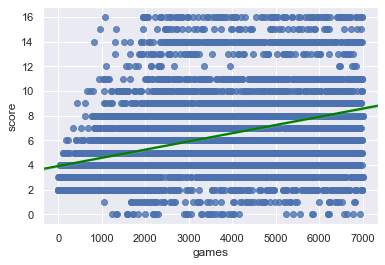

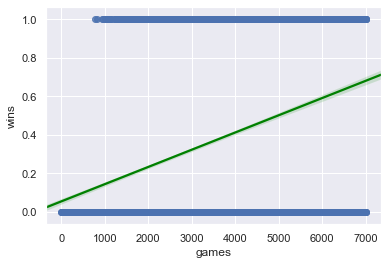

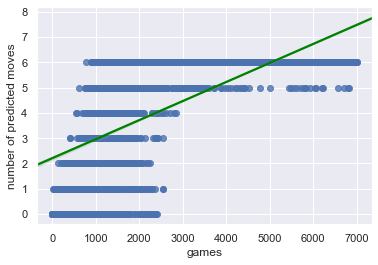

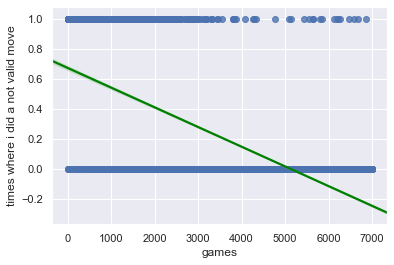

In [37]:
runS()

In [41]:
#Games against random
def runGames():
    b=SmallBoard()
    agent = DQNSmallAgent("4x4_weights_new.hdf5")
    opp=AI(0)
    d=b.get_game_over()
    i=0
    counter_games=0
    win_plot=[]
    counter_plot=[]
    counter_wrong=0
    counter_pred=0
    wrong_move=False
    while counter_games < 1000:
        wrong_move=False
        i=0
        b=SmallBoard()
        d=b.get_game_over()
        while d==False:
            if(i==0):
                try:
                    move=agent.makemove(b)
                    print(move)
                    b.coord_move(move)
                    counter_pred+=1
                except:
                    print("Player did a not valid move")
                    #ending manually the loop
                    wrong_move=True
                    counter_wrong+=1
                    counter_pred-=1
                    d=True
                i=1
            else:
                b.coord_move(opp.move(b))
                i=0
            if(d==False):
                d=b.get_game_over()
        if b.get_black_score() >= b.get_white_score():
            if(wrong_move==False):
                win_plot.append(1) 
            else:
                win_plot.append(0) 
        else:
                win_plot.append(0)
        counter_games+=1
        counter_plot.append(counter_games)
    plot_seaborn_win(counter_plot,win_plot)
    print("The percentage of wrong moves is {:.4f}".format(counter_wrong/counter_pred))
    print("The number of wrong moves is {}".format(counter_wrong))

1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ○ ○
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ● ●
4 ◦ ◦ ● ●
  A B C D
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ● ●
4 ◦ ◦ ● ●
  A B C D
Predicted move:
(3, 1)
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ● ● ●
4 ◦ ● ● ●
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ● ●
4 ○ ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ 

(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C

(3, 1)
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ○ ● ●
4 ◦ ● ● ●
  A B C D
Game over.
b'black : 10\twhite : 6'
1 ○ ○ ○ ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ● ●
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ●
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 5\twhite : 11'
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ● ● ○
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦

(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ● ○ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ○ ● ○ ◦
2 ○ ● ● ◦
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ○ ○
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
Predicted move:
(0, 3)
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ● ◦ ● ●
  A B C D
Game over.
b'black : 10\twhite : 6'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ● ●
4 ● ○ ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B 

(3, 3)
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 1)
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ○ ○ ●
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ● ○ ●
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B 

(2, 0)
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ○
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(3, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ○ ○
4 ◦ ● ● ◦
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ○ ◦
3 ○ ● ○ ○
4 ◦ ● ● ◦
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ◦
2 ○ ○ ○ ●
3 ○ ● ● ○
4 ◦ ● ● ◦
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ○ ●
3 ○ ○ ● ○
4 ○ ● ● ◦
  A B C D
Predicted move:
(3, 3)
Game over.
b'black : 6\twhite : 9'
1 ○ ○ ○ ◦
2 ○ ○ ○ ●
3 ○ ○ ● ●
4 ○ ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2

(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ● ◦
4 ● ● ● ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ●
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
Game over.
b'black : 6\twhite : 10'
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ○
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 1)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B 

1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 2)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ○ ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ○ ◦
4 ● ● ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ○ ○ ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ○ ◦
4 ● ● ● ◦
  A B C D
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ○ ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ● ◦
4 ● ● ● ●
  A B C D
Game over.
b'black : 5\twhite : 11'
1 ○ ○ ○ ○
2 ○ ● ○ ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ○
4 ◦ ◦ ● ◦
  A B C D
Pre

1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Pred

Game over.
b'black : 8\twhite : 7'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ◦ ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 1)
1 ○ ○ ○ ◦
2 ○ ○ ● ◦
3 ○ ○ ● ●
4 ◦ ○ ○ ○
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ●
4 ● ○ ○ ○
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ◦
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● 

  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ◦ ○
2 ● ● ○ ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ◦ ◦ ● ○
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ● ○
2 ● ● ● ◦
3 ○ ○ ○ ○
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ● ○
2 ● ● ● ◦
3 ○ ● ● ○
4 ◦ ◦ ● ●
  A B C D
1 ◦ ◦ ● ○
2 ● ● ○ ◦
3 ○ ○ ● ○
4 ○ ◦ ● ●
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ● ○
2 ● ● ● ●
3 ○ ○ ● ●
4 ○ ◦ ● ●
  A B C D
1 ◦ ○ ○ ○
2 ● ○ ● ●
3 ○ ○ ● ●
4 ○ ◦ ● ●
  A B C D
Predicted move:
(0, 0)
1 ● ○ ○ ○
2 ● ● ● ●
3 ○ ○ ● ●
4 ○ ◦ ● ●
  A B C D
Game over.
b'black : 11\twhite : 5'
1 ● ○ ○ ○
2 ● ● ● ●
3 ○ ● ● ●
4 ○ ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A

(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C

(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ● ◦ ○ ●
  A B C D
Predicted move:
(3, 1)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ● ● ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ● ◦
4 ● ● ● ●
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ● ● ● ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ●
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
Game over.
b'black : 6\twhite : 10'
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B 

(2, 3)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 7\twhite : 9'
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ○ ◦
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ◦
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ○ ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ◦ ○ ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ● ●
2 ● ○ ● ○
3 ● ○ ○ ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ● ● ●
2 ● ● ● ○
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 14\twhite : 2'
1 ● ● ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ 

(0, 2)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ○ ○ ●
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ● ○ ●
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ● ○ ●
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 2)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B 

1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ○ ○
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ● ●
4 ◦ ◦ ● ●
  A B C D
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ● ●
4 ◦ ◦ ● ●
  A B C D
Predicted move:
(3, 1)
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ● ● ●
4 ◦ ● ● ●
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ● ●
4 ○ ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Pred

1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ○ ○
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
Predicted move:
(0, 2)
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ● ○ ● ●
  A B C D
Pred

(1, 3)
1 ◦ ○ ◦ ◦
2 ● ● ● ●
3 ○ ● ● ●
4 ◦ ● ◦ ●
  A B C D
1 ○ ○ ◦ ◦
2 ○ ● ● ●
3 ○ ● ● ●
4 ◦ ● ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ○ ○ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ●
4 ◦ ● ◦ ●
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ○ ●
3 ○ ○ ○ ●
4 ◦ ● ○ ●
  A B C D
Predicted move:
(3, 0)
Game over.
b'black : 3\twhite : 12'
1 ○ ○ ○ ◦
2 ○ ○ ○ ●
3 ○ ○ ○ ●
4 ○ ○ ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ◦ ○
2 ● ● ○ ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ◦ ◦ ● ○
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ● ○
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ● ○
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ○ ○ ○
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(3, 1)
1 ○ ○ ○ ○
2 ○ ○ ● ◦
3 ○ ○ ● ◦
4 ● ○ ◦ ●
  A B C D
1 ○ ○ ○ ○
2 ○ ○ ● ◦
3 ○ ○ ● ◦
4 ● ● ● ●
  A B 

(0, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ◦
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ○ ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ◦ ○ ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ● ●
2 ● ○ ● ○
3 ● ○ ○ ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ● ● ●
2 ● ● ● ○
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 14\twhite : 2'
1 ● ● ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B 

(0, 3)
1 ○ ○ ○ ●
2 ● ● ● ●
3 ● ● ● ●
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 9\twhite : 7'
1 ○ ○ ○ ●
2 ● ● ○ ●
3 ● ● ○ ●
4 ● ○ ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦

(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ● ○
3 ● ○ ○ ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(2, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ●
3 ● ● ● ●
4 ● ○ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
Predicted move:
(0, 0)
1 ● ○ ◦ ●
2 ● ● ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
Game over.
b'black : 16\twhite : 0'
1 ● ● ● ●
2 ● ● ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B 

Game over.
b'black : 15\twhite : 1'
1 ● ● ● ○
2 ● ● ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ●
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ○ ● ●
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 5\twhite : 11'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ● ○ ●
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ●

4 ● ● ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 3)
Game over.
b'black : 8\twhite : 7'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ● ● ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ● ● ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 7\twhite : 9'
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ● ● ○
4 ● ● ● ○
  A B C D

3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(2, 0)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ● ○ ● ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ○ ○ ● ◦
  A B C D
Predicted move:
(2, 3)
1 ○ ◦ ◦ ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ○ ○ ● ◦
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ●
3 ○ ● ○ ●
4 ○ ○ ○ ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ●
2 ○ ● ● ●
3 ○ ● ○ ●
4 ○ ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ● ○ ●
4 ○ ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦

1 ○ ● ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ● ○ ●
  A B C D
Predicted move:
(0, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ● ○ ●
4 ● ● ○ ●
  A B C D
Game over.
b'black : 7\twhite : 9'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ● ○ ●
4 ● ● ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ● ● ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 3)
Game over.
b'black : 8\twhite : 7'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦

1 ◦ ○ ○ ○
2 ● ○ ● ●
3 ○ ○ ● ●
4 ◦ ○ ● ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ○ ○
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
Game over.
b'black : 13\twhite : 3'
1 ● ○ ○ ○
2 ● ● ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ● ○
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ○
3 ○ ● ● ○
4 ◦ ◦ ● ○
  A B C D
1 ○ ○ ○ ●
2 ○ ○ ● ○
3 ○ ● ● ○
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 1)
1 ○ ○ ○ ●
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ●

1 ○ ◦ ◦ ○
2 ○ ● ○ ◦
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
Predicted move:
(1, 3)
1 ○ ◦ ◦ ○
2 ○ ● ● ●
3 ○ ○ ● ●
4 ● ◦ ● ●
  A B C D
Game over.
b'black : 7\twhite : 7'
1 ○ ◦ ○ ○
2 ○ ○ ● ●
3 ○ ○ ● ●
4 ● ◦ ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 2)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ○ ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ○ ◦
4 ● ● ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ○ ○ ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ○ ◦
4 ● ● ● ◦
  A B C D
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ○ ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ● ◦
4 ● ● ● ●
  A B C D
Game over.
b'black : 5\twhite : 11'
1 ○ ○ ○ ○
2 ○ ● ○ 

Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ○ ◦
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
Predicted move:
(0, 3)
1 ○ ○ ○ ●
2 ○ ○ ● ◦
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ○ ○ ●
2 ○ ○ ● ◦
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ○ ○ ●
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● 

1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ● ◦
4 ● ● ● ●
  A B C D
Game over.
b'black : 5\twhite : 11'
1 ○ ○ ○ ○
2 ○ ● ○ ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Predicted move:
(0, 3)
Game over.
b'black : 6\twhite : 9'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● 

(0, 3)
1 ◦ ◦ ○ ●
2 ● ○ ● ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
1 ◦ ○ ○ ●
2 ● ○ ○ ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
Predicted move:
(1, 3)
1 ◦ ○ ○ ●
2 ● ● ● ●
3 ○ ● ● ●
4 ◦ ● ◦ ●
  A B C D
1 ◦ ○ ○ ●
2 ● ● ○ ●
3 ○ ● ○ ●
4 ◦ ● ○ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ○ ●
2 ● ● ○ ●
3 ● ● ○ ●
4 ● ● ○ ●
  A B C D
Game over.
b'black : 9\twhite : 7'
1 ○ ○ ○ ●
2 ● ○ ○ ●
3 ● ● ○ ●
4 ● ● ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ○ ○
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ● ●
4 ◦ ◦ ● ●
  A B C

3 ○ ● ○ ●
4 ◦ ● ○ ●
  A B C D
Game over.
b'black : 11\twhite : 5'
1 ● ● ● ●
2 ● ● ● ●
3 ○ ● ○ ●
4 ○ ○ ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted m

4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2

1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ○ ○
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ● ●
4 ◦ ◦ ● ●
  A B C D
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ● ●
4 ◦ ◦ ● ●
  A B C D
Predicted move:
(3, 1)
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ● ● ●
4 ◦ ● ● ●
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ● ●
4 ○ ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Pred

1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 2)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ○ ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ○ ◦
4 ● ● ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ○ ○ ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ○ ◦
4 ● ● ● ◦
  A B C D
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ○ ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ● ◦
4 ● ● ● ●
  A B C D
Game over.
b'black : 5\twhite : 11'
1 ○ ○ ○ ○
2 ○ ● ○ ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ○ ● ◦
4 ● ○ ◦ ●
  A B C D
Pre

  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ○ ◦
3 ● ● ○ ◦
4 ● ◦ ○ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ◦ ○ ●
2 ● ○ ● ◦
3 ● ● ○ ◦
4 ● ◦ ○ ●
  A B C D
1 ◦ ◦ ○ ●
2 ● ○ ● ◦
3 ● ○ ○ ◦
4 ● ○ ○ ●
  A 

1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ○
4 ◦ ● ○ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ○ ○
4 ● ● ○ ●
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ○ ◦
3 ○ ● ○ ○
4 ● ● ○ ●
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ◦
2 ○ ○ ○ ●
3 ○ ● ● ●
4 ● ● ○ ●
  A B C D
Game over.
b'black : 9\twhite : 7'
1 ○ ○ ○ ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ● ● ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ● ○ ◦
2 ○ ● ○ ◦
3 ○ ○ ○ ◦
4 ● ◦ ○ ●
  A B C D
Predicted move:
(1, 3)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ○ ◦
4 ● ◦ ○ ●
  A B C D
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ○ ◦
4 ● ◦ ○ ●
  A B C D
Pred

1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ○
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 1)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
1 ○ 

(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ○ ◦
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
Predicted move:
(0, 3)
1 ○ ○ ○ ●
2 ○ ○ ● ◦
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ○ ○ ●
2 ○ ○ ● ◦
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ○ ○ ●
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B 

1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game

1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ○ ○ ◦
2 ● ● ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ○ ○ ○ ●
2 ● ● ● ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ○ ○ ●
2 ● ○ ● ○
3 ● ○ ○ ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ●
2 ● ○ ● ●
3 ● ● ● ●
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ●
2 ● ○ ○ ●
3 ● ● ○ ●
4 ● ○ ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ◦
2 ○ ○ ○ ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ 

(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 3)
Game over.
b'black : 8\twhite : 7'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 

(0, 1)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ● ●
4 ◦ ○ ○ ○
  A B C D
1 ○ ● ◦ ◦
2 ● ● ● ○
3 ◦ ● ○ ○
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(2, 0)
1 ○ ● ◦ ◦
2 ○ ● ● ○
3 ○ ○ ○ ○
4 ◦ ○ ○ ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
Predicted move:
(0, 3)
Player did a not valid move
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ●
4

(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 2)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ○ ○ ●
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ● ◦
2 ○ ○ ● ○
3 ○ ● ○ ●
4 ● ○ ○ ○
  A B C

(3, 1)
1 ○ ○ ○ ○
2 ○ ● ○ ○
3 ○ ● ● ○
4 ◦ ● ● ●
  A B C D
Game over.
b'black : 5\twhite : 11'
1 ○ ○ ○ ○
2 ○ ● ○ ○
3 ○ ○ ● ○
4 ○ ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(2, 0)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ● ○ ● ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ○ ●
2 ● ○ ○ ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(2, 3)
1 ○ ◦ ○ ●
2 ● ○ ○ ●
3 ● ● ● ●
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ○ ●
2 ○ ○ ○ ●
3 ○ ○ ● ●
4 ○ ○ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ● ●
4 ○ ○ ● ◦
  A B C D
Game over.
b'black : 6\twhite : 10'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ○ ●
4 ○ ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦

1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Pred

3 ○ ○ ○ ○
4 ◦ ○ ○ ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
Predicted move:
(0, 3)
Player did a not valid move
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ○ ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ◦ ○ ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ● ●
2 ● ○ ● ○
3 ● ○ ○ ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ● ● ●
2 ● ● ● ○
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 14\twhite : 2'
1 ● ● ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B

1 ◦ ○ ● ●
2 ● ○ ● ○
3 ● ○ ○ ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ● ● ●
2 ● ● ● ○
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 14\twhite : 2'
1 ● ● ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● 

4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Predicted move:
(0, 3)
Game over.
b'black : 6\twhite : 9'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ○ ● ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ○ ◦ ◦
2

1 ○ ○ ○ ◦
2 ○ ○ ● ◦
3 ○ ○ ● ●
4 ◦ ○ ○ ○
  A B C D
1 ○ ○ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ●
4 ● ○ ○ ○
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ◦
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ○ ● ●
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ◦ ◦
2 ○ ○ ● ◦
3 ○ ● ● ●
4 ● ○ ○ ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
Predicted move:
(0, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
Gam

1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 2)
1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 1)
1 ○ ○ ○ ○
2 ○ ○ ● ○
3 ○ ○ ○ ●
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ○
2 ○ ○ ● 

(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ● ◦
4 ● ● ● ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ●
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
Game over.
b'black : 6\twhite : 10'
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B 

1 ○ ◦ ● ◦
2 ● ○ ● ○
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ● ◦
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ● ◦
4 ◦ ○ ● ●
  A B C D
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ○ ○ ○
4 ◦ ○ ● ●
  A B C D
Predicted move:
(3, 0)
1 ○ ● ● ◦
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
Game over.
b'black : 7\twhite : 9'
1 ○ ○ ○ ○
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ 

1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ● ◦
4 ● ● ● ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ●
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
Game over.
b'black : 6\twhite : 10'
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Pre

(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ○ ◦
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ◦
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ○ ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ◦ ○ ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ● ●
2 ● ○ ● ○
3 ● ○ ○ ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ● ● ●
2 ● ● ● ○
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 14\twhite : 2'
1 ● ● ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B 

4 ◦ ● ○ ●
  A B C D
Predicted move:
(3, 0)
Game over.
b'black : 3\twhite : 12'
1 ○ ○ ○ ◦
2 ○ ○ ○ ●
3 ○ ○ ○ ●
4 ○ ○ ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ● ○ ◦
2 ● ● ○ ○
3 ● ● ○ ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(2, 3)
1 ◦ ● ○ ◦
2 ● ● ● ○
3 ● ● ● ●
4 ● ○ ◦ ●
  A B C D
1 ◦ ● ○ ◦
2 ● ● ○ ○
3 ● ● ○ ●
4 ● ○ ○ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ● ● ●
2 ● ● ● ●
3 ● ● ○ ●
4 ● ○ ○ ●
  A B C D
Game over.
b'black : 11\twhite : 5'
1 ○ ● ● ●
2 ● ○ ● ●
3 ● ● ○ ●
4 ● ○ ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C

2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ● ● ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ● ● ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ● ● ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ○ ○
4 ● ● ● ◦
  A B C D
Predicted move:
(3, 3)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ○ ● ●
4 ● ● ● ●
  A B C D
Game over.
b'black : 9\twhite : 7'
1 ○ ● ○ ○
2 ○ ● ○ ●
3 ○ ○ ● ●
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● 

1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ● ●
4 ◦ ○ ○ ○
  A B C D
1 ○ ● ○ ○
2 ● ● ● ○
3 ◦ ● ● ○
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(2, 0)
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ○ ◦
3 ● ● ○ ◦
4 ● ◦ ○ ●
  A B C D
Pre

1 ○ ◦ ◦ ●
2 ● ○ ● ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ○ ●
2 ● ○ ○ ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(2, 3)
1 ○ ◦ ○ ●
2 ● ○ ○ ●
3 ● ● ● ●
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ○ ●
2 ● ○ ○ ●
3 ● ● ○ ●
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ● ●
2 ● ● ● ●
3 ● ● ○ ●
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ● ● ●
2 ○ ● ● ●
3 ○ ● ○ ●
4 ○ ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ 

1 ◦ ○ ◦ ◦
2 ● ○ ○ ◦
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ◦
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ○ ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 2)
1 ◦ ○ ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ● ●
2 ● ○ ● ○
3 ● ○ ○ ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ● ● ●
2 ● ● ● ○
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
Game over.
b'black : 14\twhite : 2'
1 ● ● ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ○ ● ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ○ ◦ ◦
2 ● ● ● ◦
3 ● ○ ● ◦
4 ● ○ ◦ ●
  A B C D
1 ● ○ ◦ ○
2 ● ● ○ ◦
3 ● ○ ● ◦
4 ● ○ ◦ ●
  A B C D
Pre

3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
Predicted move:
(0, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ● ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ○ ○ ●
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ○ ○ ●
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ○
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 1)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ○ ◦
3 ○

  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ● ○
3 ● ○ ○ ◦
4 ● ○ ◦ ●
  A B C D
Predicted move:
(2, 3)
1 ◦ ○ ◦ ●
2 ● ○ ● ●
3 ● ● ● ●
4 ● ○ ◦ ●
  A B C D
1 ◦ ○ ◦ ●
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
Predicted move:
(0, 0)
1 ● ○ ◦ ●
2 ● ● ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
Game over.
b'black : 16\twhite : 0'
1 ● ● ● ●
2 ● ● ● ●
3 ● ● ● ●
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ◦ ◦
2 ● ○ ● ◦


2 ○ ● ● ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
1 ○ ● ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ● ○ ●
4 ◦ ● ◦ ●
  A B C D
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ○ ○ ●
4 ◦ ● ○ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ● ◦ ●
2 ○ ○ ● ●
3 ○ ● ○ ●
4 ● ● ○ ●
  A B C D
Game over.
b'black : 7\twhite : 9'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ● ○ ●
4 ● ● ○ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ● ● ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ 

1 ◦ ○ ◦ ●
2 ● ○ ● ◦
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(0, 0)
1 ● ○ ◦ ●
2 ● ● ● ◦
3 ● ○ ● ○
4 ● ○ ◦ ●
  A B C D
1 ● ○ ◦ ●
2 ● ● ● ○
3 ● ○ ○ ○
4 ● ○ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ● ○ ◦ ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
Game over.
b'black : 14\twhite : 2'
1 ● ● ● ●
2 ● ● ● ○
3 ● ● ● ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ○ ○
3 ● ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ◦ ● ○ ◦
2 ● ● ○ ○
3 ● ● ○ ◦
4 ● ◦ ○ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ● ● ●
2 ● ● ● ○
3 ● ● ○ ◦
4 ● ◦ ○ ●
  A B C D
1 ○ ● ● ●
2 ● ○ ● ○
3 ● ● ○ ◦
4 ● ◦ ○ ●
  A B C D
Pre

1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ● ◦
4 ● ● ● ●
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ● ● ● ●
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ●
2 ○ ● ● ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
Game over.
b'black : 6\twhite : 10'
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ● ● ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 3)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ○ ○ ○
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 1)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ○ ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
Predicted move:
(0, 3)
1 ◦ ◦ ○ ●
2 ● ○ ● ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
1 ◦ ○ ○ ●
2 ● ○ ○ ◦
3 ○ ● ○ ○
4 ◦ ● ◦ ●
  A B C D
Predicted move:
(1, 3)
1 ◦ ○ ○ ●
2 ● ● ● ●
3 ○ ● ● ●
4 ◦ ● ◦ ●
  A B C D
1 ◦ ○ ○ ●
2 ● ● ○ ●
3 ○ ● ○ ●
4 ◦ ● ○ ●
  A B C D
Predicted move:
(3, 0)
1 ◦ ○ ○ ●
2 ● ● ○ ●
3 ● ● ○ ●
4 ● ● ○ ●
  A B C D
Gam

Game over.
b'black : 7\twhite : 9'
1 ○ ○ ○ ●
2 ○ ○ ● ●
3 ○ ○ ○ ●
4 ● ○ ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ○ ◦
4 ● ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
Predicted move:
(0, 3)
Game over.
b'black : 6\twhite : 9'
1 ○ ● ● ●
2 ○ ○ ● ●
3 ○ ○ ○ ◦
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦

1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 3)
1 ○ ○ ○ ●
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ○ ○ ●
2 ● ● ○ ◦
3 ◦ ● ○ ○
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(1, 3)
1 ○ ○ ○ ●
2 ● ● ● ●
3 ◦ ● ○ ○
4 ◦ ◦ ● ○
  A B C D
1 ○ ○ ○ ●
2 ● ○ ● ●
3 ◦ ○ ○ ○
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(3, 0)
1 ○ ○ ○ ●
2 ● ○ ● ●
3 ◦ ● ○ ○
4 ● ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ● 

(0, 2)
1 ◦ ◦ ● ○
2 ● ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
1 ○ ◦ ● ○
2 ○ ● ● ◦
3 ○ ○ ● ◦
4 ◦ ◦ ◦ ●
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ● ○
2 ○ ● ● ◦
3 ○ ● ● ◦
4 ● ◦ ◦ ●
  A B C D
1 ○ ◦ ● ○
2 ○ ● ● ◦
3 ○ ○ ○ ○
4 ● ◦ ◦ ●
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ● ○
2 ○ ● ● ◦
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
1 ○ ◦ ● ○
2 ○ ○ ○ ○
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
Predicted move:
(0, 1)
1 ○ ○ ○ ○
2 ○ ○ ○ ○
3 ○ ○ ● ○
4 ● ◦ ● ●
  A B C D
Game over.
b'black : 3\twhite : 13'
1 ○ ○ ○ ○
2 ○ ○ ○ ○
3 ○ ○ ○ ○
4 ● ○ ● ●
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B 

(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 0)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ○ ○ ◦
4 ● ○ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ● ◦
4 ● ● ● ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(0, 1)
1 ◦ ● ○ ◦
2 ● ● ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ○ ◦
4 ● ● ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ○ ○ ◦
2 ● ○ ● ●
3 ● ● ● ●
4 ● ● ● ○
  A B C D
Game over.
b'black : 8\twhite : 8'
1 ○ ○ ○ ○
2 ● ○ ● ○
3 ● ● ● ○
4 ● ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦

(0, 1)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ○ ◦
2 ● ● ● ●
3 ◦ ● ● ●
4 ◦ ○ ○ ○
  A B C D
1 ○ ● ○ ○
2 ● ● ● ○
3 ◦ ● ● ○
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(2, 0)
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ○ ○ ○
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 4\twhite : 12'
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ● ○ ○
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(2, 0)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ● ● ● ◦
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ○ ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(0, 3)
1 ○ ◦ ◦ ●
2 ● ○ ● ○
3 ● ● ○ ◦
4 ◦ ○ ● ◦
  A B C D
1 ○ ◦ ◦ ●
2 ○ ○ ● ○
3 ○ ● ○ ◦
4 ○ ○ ● ◦
  A B C D
Predicted move:
(2, 3)
1 ○ ◦ ◦ ●
2 ○ ○ ● ●
3 ○ ● ● ●
4 ○ ○ ● ◦
  A B 

1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
Predicted move:
(0, 1)
1 ○ ● ○ ◦
2 ○ ● ● ●
3 ○ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ○ ◦
2 ○ ○ ● ●
3 ○ ● ● ●
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ○ ○
2 ○ ○ ● ○
3 ○ ● ● ○
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(3, 0)
1 ○ ● ○ ○
2 ○ ○ ○ ○
3 ○ ○ ● ○
4 ○ ◦ ● ○
  A B C D
Game over.
b'black : 6\twhite : 10'
1 ○ ● ○ ○
2 ○ ● ○ ○
3 ○ ● ● ○
4 ○ ● ● ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ◦ ○ ◦
2 ● ● ○ ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 3)
1 ◦ ◦ ○ ◦
2 ● ● ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ○ ● ◦
4 ◦ ○ ● ◦
  A B C D
Predicted move:
(3, 0)
1 ○ ◦ ○ ◦
2 ● ○ ● ●
3 ◦ ● ● ◦
4 ● ● ● ◦
  A B C D
1 ○

Game over.
b'black : 4\twhite : 12'
1 ○ ○ ○ ●
2 ○ ○ ○ ●
3 ○ ○ ○ ●
4 ● ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(3, 2)
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ● ◦
4 ◦ ◦ ● ◦
  A B C D
1 ○ ◦ ◦ ◦
2 ● ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
Predicted move:
(0, 1)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ● ○
  A B C D
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(2, 3)
1 ○ ● ◦ ◦
2 ● ● ● ◦
3 ◦ ● ● ●
4 ◦ ○ ○ ○
  A B C D
1 ○ ● ◦ ◦
2 ○ ● ● ◦
3 ○ ● ● ●
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(1, 3)
1 ○ ● ◦ ◦
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ◦ ○ ○ ○
  A B C D
1 ○ ● ◦ ●
2 ○ ○ ● ○
3 ○ ● ○ ○
4 ◦ ○ ○ ○
  A B C D
Predicted move:
(0, 2)
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ● ○ ○
4 ◦ ○ ○ ○
  A B C D
Game over.
b'black : 1\twhite : 15'
1 ○ ○ ○ ●
2 ○ ○ ○ ○
3 ○ ○ ○ ○
4 ○ ○ ○ ○
  A B C D
1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
Predicted move:
(1, 0)
1 ◦ ◦ ◦ ◦
2 ● ● ●

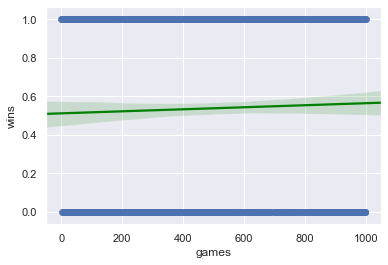

The percentage of wrong moves is 0.0047
The number of wrong moves is 28


In [42]:
runGames()

In [33]:
#Plotting the Q-function
def plotQ():
    b=SmallBoard()
    agent = DQNSmallAgent("4x4_randomweights_3layers_good.hdf5")
    agentBad =DQNSmallAgent("4x4_weights_smalltrain.hdf5")
    b.human_move("B1")
    b.human_move("A3")
    state_old = agent.get_state(b)
    pred=agent.model.predict(state_old.reshape((1,16)))[0]
    predBad=agentBad.model.predict(state_old.reshape((1,16)))[0]
    mov=np.argmax(pred)
    row=mov//4
    column=mov%4
    action=(row,column)
    b.coord_move(action)
    print("\nQ-function of trained agent:")
    print(pred[0],"\t",pred[1],"\t" ,pred[2],"\t",pred[3])
    print(pred[4],"\t", pred[5],"\t", pred[6],"\t", pred[7])
    print(pred[8],"\t", pred[9],"\t", pred[10],"\t", pred[11])
    print(pred[12],"\t", pred[13],"\t", pred[14],"\t", pred[15])
    print("\nQ-function of short trained agent:")
    print(predBad[0],"\t",predBad[1],"\t" ,predBad[2],"\t",predBad[3])
    print(predBad[4],"\t", predBad[5],"\t", predBad[6],"\t", predBad[7])
    print(predBad[8],"\t", predBad[9],"\t", predBad[10],"\t", predBad[11])
    print(predBad[12],"\t", predBad[13],"\t", predBad[14],"\t", predBad[15])

In [34]:
plotQ()

1 ◦ ◦ ◦ ◦
2 ◦ ○ ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ● ◦ ◦
2 ◦ ● ● ◦
3 ◦ ● ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ● ◦ ◦
2 ◦ ● ● ◦
3 ○ ○ ○ ◦
4 ◦ ◦ ◦ ◦
  A B C D
1 ◦ ● ◦ ◦
2 ◦ ● ● ◦
3 ○ ● ○ ◦
4 ◦ ● ◦ ◦
  A B C D

Q-function of trained agent:
7.788171e-12 	 5.9560186e-16 	 3.6487373e-09 	 3.5780331e-10
3.3457832e-07 	 2.365053e-21 	 3.6767714e-21 	 2.3967648e-09
5.2521425e-11 	 1.5561957e-21 	 2.2788872e-21 	 5.2619168e-08
3.0647536e-06 	 0.99999034 	 5.3167e-07 	 5.677239e-06

Q-function of short trained agent:
0.039662585 	 0.064819194 	 0.016968185 	 0.076259896
0.21008962 	 0.009687764 	 0.0060026348 	 0.024160553
0.01781183 	 0.009611703 	 0.009583539 	 0.15350941
0.16079202 	 0.029436512 	 0.1444915 	 0.027113046
